# Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive') #/My Drive/Colab Notebooks/imagenet

Mounted at /content/drive


In [ ]:
# Dany's Directory
%cd /content/drive/My Drive/Colab Notebooks/imagenet/

/content/drive/My Drive/Colab Notebooks/imagenet


In [2]:
# Caroline's Directory
%cd /content/drive/My Drive/imagenet/

/content/drive/.shortcut-targets-by-id/1cZ-V95iJX2lZXKQeHjcbONaKRVlwKagP/imagenet


In [ ]:
# Christopher's directory
%cd /content/drive/My Drive/imagenet/

# Import Libraries

In [3]:
import os
import cv2
import shutil
import random
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [4]:
!pip install tensorflow --q

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

In [6]:
# Sample images and move them to the proper directories
random.seed(42)
src_path = os.getcwd()

# Read Data

In [7]:
training_path = os.getcwd() + '/preliminary_model_testing_data/train'
validation_path = os.getcwd() + '/preliminary_model_testing_data/validation'
testing_path = os.getcwd() + '/preliminary_model_testing_data/test'

In [8]:
# Create Image Data Generator instance
data_generator = ImageDataGenerator() # rescale=1.0/255.0, featurewise_center=True, horizontal_flip=True, brightness_range=[0.7,1.3], zoom_range=[0.7, 1.3], shear_range = 0.2,

# Create training iterator, validation iterator & testing iterator
train_it = data_generator.flow_from_directory(training_path,
                                              class_mode="binary",
                                              batch_size=32,
                                              target_size = (224, 224))

validation_it = data_generator.flow_from_directory(validation_path,
                                                   class_mode="binary",
                                                   batch_size=16,
                                                   target_size = (224, 224))

test_it = data_generator.flow_from_directory(testing_path,
                                             class_mode="binary",
                                             batch_size=16,
                                             target_size = (224, 224))

batchX, batchY = train_it.next()
print("BatchX shape: {}, min: {}, max: {}".format(batchX.shape, batchX.min(), batchX.max()))
print("BatchY shape: {}".format(batchY.shape))

Found 4000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
BatchX shape: (32, 224, 224, 3), min: 0.0, max: 255.0
BatchY shape: (32,)


# EfficientNetB7

In [9]:
# Re-size all the images to this
IMAGE_SIZE = [224, 224] # The ResNet50 model was originally trained on images of this size from the ImageNet dataset.

In [10]:
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Model

In [11]:
# Load the pre-trained EfficientNetB0 model
efficient_net = EfficientNetB7(weights='imagenet', include_top=False, input_shape=IMAGE_SIZE + [3])

# Freeze the base model layers
for layer in efficient_net.layers:
    layer.trainable = False

258076736/258076736 [==============================] - 2s 0us/step


In [12]:
# Flatten the output of the EfficientNet base model
x = Flatten()(efficient_net.output)

# Add additional dense layers
prediction = Dense(1, activation='sigmoid')(x) # creating a dense (fully connected) layer as the final output layer for our classification task.

In [13]:
# Create the model
model = Model(inputs=efficient_net.input, outputs=prediction)

In [14]:
# Compile Model
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Callbacks
callbacks = [
    ModelCheckpoint("Models/PreliminaryTesting/EfficientNetB7_no_rescaling_model.h5", save_freq = 5, save_weights_only = True)
]

# Fit the model with early stopping callback
history = model.fit_generator(
  train_it,
  validation_data=validation_it,
  epochs=20,
  steps_per_epoch=10,
  validation_steps=5,
  verbose=1,
  callbacks=callbacks
)

<ipython-input-15-561c2e1ea35b>:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/20
10/10 [==============================] - 156s 10s/step - loss: 4.2026 - accuracy: 0.5281 - val_loss: 5.9387 - val_accuracy: 0.4875
Epoch 2/20
10/10 [==============================] - 67s 7s/step - loss: 3.7685 - accuracy: 0.5156 - val_loss: 2.7365 - val_accuracy: 0.5500
Epoch 3/20
10/10 [==============================] - 78s 8s/step - loss: 2.4274 - accuracy: 0.6156 - val_loss: 1.8141 - val_accuracy: 0.6000
Epoch 4/20
10/10 [==============================] - 87s 9s/step - loss: 1.6199 - accuracy: 0.6313 - val_loss: 1.6938 - val_accuracy: 0.5500
Epoch 5/20
10/10 [==============================] - 57s 6s/step - loss: 1.5100 - accuracy: 0.6094 - val_loss: 1.1923 - val_accuracy: 0.5625
Epoch 6/20
10/10 [==============================] - 59s 6s/step - loss: 1.0790 - accuracy: 0.6656 - val_loss: 1.5086 - val_accuracy: 0.6375
Epoch 7/20
10/10 [==============================] - 46s 5s/step - loss: 1.0891 - accuracy: 0.7406 - val_loss: 1.4647 - val_accuracy: 0.5875
Epoch 8/20
10/10 [

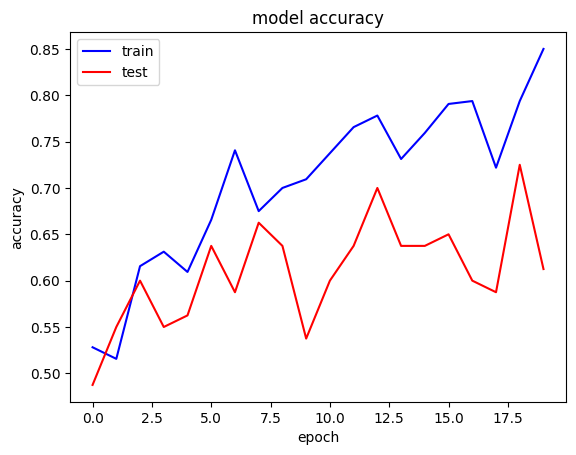

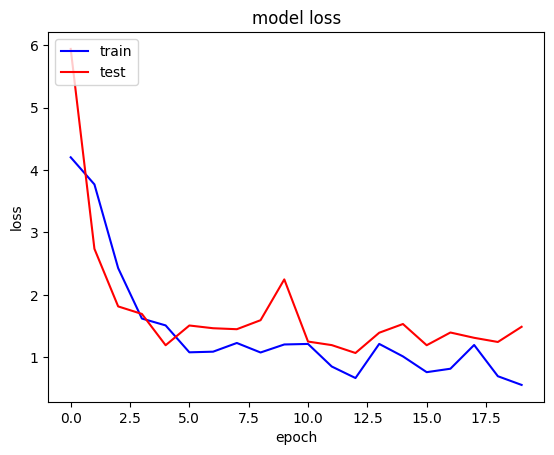

In [16]:
# Plot the model's training and validation accuracy
plt.plot(history.history['accuracy'], color='blue')
plt.plot(history.history['val_accuracy'], color='red')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Plot the model's training and validation loss
plt.plot(history.history['loss'], color='blue')
plt.plot(history.history['val_loss'], color='red')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Model Testing

In [17]:
model.evaluate(test_it, batch_size=5)

25/25 [==============================] - 99s 4s/step - loss: 1.8014 - accuracy: 0.5800


[1.8013964891433716, 0.5799999833106995]